In [1]:
import time
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models,transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader,random_split
#from __future__ import print_function
import numpy as np 
import pandas as pd
import os
import random
import matplotlib.pyplot as plt 
from torch.autograd import Function
from collections import OrderedDict
import torch.nn as nn
import math
import torchvision.models as models
import pickle
import cv2
from transformers import data
import wandb
from sklearn.model_selection import KFold
# from torchsummary import summary
from datetime import timedelta

/home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-14 13:49:54.840118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-14 13:49:54.987036: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-14 13:49:55.014563: E tensorflow/stream_executor/cuda/cuda_blas.cc:2

In [2]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):

    def __init__(self, z_dim=128):
        super(ResNet18Enc, self).__init__()
        self.z_dim = z_dim
        self.ResNet18 = models.resnet18(pretrained=True)
        self.num_features = self.ResNet18.fc.in_features
        self.ResNet18.fc = nn.Linear(self.num_features, 2*self.z_dim)

    def forward(self, x):
        x = self.ResNet18(x)
        mu = x[:, :self.z_dim]
        logvar = x[:, self.z_dim:]
        return mu, logvar

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=128, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=7)
        x = self.layer4(x)
#         x = F.interpolate(x, scale_factor=2)
        x = self.layer3(x)
#         x = F.interpolate(x, scale_factor=2)
        x = self.layer2(x)
#         x = F.interpolate(x, scale_factor=2)
        x = self.layer1(x)
        x = F.interpolate(x, size=(112,112), mode='bilinear')
        x = torch.sigmoid(self.conv1(x))
        x = x.view(x.size(0), 3, 224, 224)
        return x

class VAE(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        r = self.decoder(z)
        return r, mean, logvar
    
    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

In [3]:
zsize = 128
vae = VAE(zsize)
vae = nn.DataParallel(vae)
vae = vae.cuda()

In [4]:
def loss_functionVAE(recon_x, x, mu, logvar):
#     BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1+logvar - mu.pow(2) - logvar.exp())
#     x = x[:, 0, :, :]
    MSE = nn.MSELoss()(recon_x, x)
    beta = 1
    return MSE + beta*KLD, MSE, KLD

In [5]:
number_of_epochs = 1000
learningRate= 0.0001

autoencoder_optimizer = optim.Adam(vae.parameters(), lr = learningRate)
scheduler = optim.lr_scheduler.StepLR(autoencoder_optimizer, step_size=30, gamma = 0.1)

In [6]:
MNISTtransform = transforms.Compose([transforms.Resize([224, 224]),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                std = [0.229, 0.224, 0.225])])

In [7]:
MNIST_train_dataset = torchvision.datasets.MNIST(root=".", train=True, transform=MNISTtransform, download=True)
MNIST_test_dataset = torchvision.datasets.MNIST(root=".", train=False, transform=MNISTtransform)

# Make Dataset Smaller for faster training
odds = list(range(1, len(MNIST_train_dataset), 40))
smallMNIST_train = torch.utils.data.Subset(MNIST_train_dataset, odds)
evens = list(range(1, len(MNIST_test_dataset), 40))
smallMNIST_test = torch.utils.data.Subset(MNIST_test_dataset, evens)


train_set_loader = torch.utils.data.DataLoader(dataset=smallMNIST_train, batch_size=64, shuffle=True)
test_set_loader = torch.utils.data.DataLoader(dataset=smallMNIST_test, batch_size=64, shuffle=False)

/home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


[1] Loss -> Training: 6846.2810631 | Validation: 444.6415558 in 5.82 seconds.
[2] Loss -> Training: 163.2454367 | Validation: 88.0985756 in 5.20 seconds.
[3] Loss -> Training: 61.8747084 | Validation: 18.0078702 in 5.21 seconds.
[4] Loss -> Training: 52.9496973 | Validation: 9.1783211 in 5.35 seconds.
[5] Loss -> Training: 50.6812080 | Validation: 8.5980239 in 5.44 seconds.
[6] Loss -> Training: 49.4981401 | Validation: 8.3580134 in 5.29 seconds.
[7] Loss -> Training: 48.6464932 | Validation: 8.1968949 in 5.27 seconds.
[8] Loss -> Training: 47.9857861 | Validation: 8.0776310 in 5.19 seconds.
[9] Loss -> Training: 47.4809265 | Validation: 7.9804223 in 5.28 seconds.
[10] Loss -> Training: 47.0340496 | Validation: 7.9001938 in 5.20 seconds.
[11] Loss -> Training: 46.6801969 | Validation: 7.8365330 in 5.19 seconds.
[12] Loss -> Training: 46.4073712 | Validation: 7.7828377 in 5.37 seconds.
[13] Loss -> Training: 46.1589245 | Validation: 7.7374493 in 5.31 seconds.
[14] Loss -> Training: 45.9

[111] Loss -> Training: 43.7426782 | Validation: 7.2824837 in 5.39 seconds.
[112] Loss -> Training: 43.7429066 | Validation: 7.2825108 in 5.22 seconds.
[113] Loss -> Training: 43.7498411 | Validation: 7.2813344 in 5.25 seconds.
[114] Loss -> Training: 43.7422289 | Validation: 7.2814188 in 5.29 seconds.
[115] Loss -> Training: 43.7292970 | Validation: 7.2809756 in 5.26 seconds.
[116] Loss -> Training: 43.7383591 | Validation: 7.2811515 in 5.25 seconds.
[117] Loss -> Training: 43.7360293 | Validation: 7.2798053 in 5.26 seconds.
[118] Loss -> Training: 43.7296013 | Validation: 7.2824317 in 5.25 seconds.
[119] Loss -> Training: 43.7377863 | Validation: 7.2801808 in 5.26 seconds.
[120] Loss -> Training: 43.7223958 | Validation: 7.2802243 in 5.29 seconds.
[121] Loss -> Training: 43.7314883 | Validation: 7.2782018 in 5.24 seconds.
[122] Loss -> Training: 43.7265151 | Validation: 7.2790574 in 5.23 seconds.
[123] Loss -> Training: 43.7224444 | Validation: 7.2783219 in 5.24 seconds.
[124] Loss -

[219] Loss -> Training: 43.7105819 | Validation: 7.2753000 in 5.23 seconds.
[220] Loss -> Training: 43.7144072 | Validation: 7.2730225 in 5.22 seconds.
[221] Loss -> Training: 43.7063370 | Validation: 7.2721373 in 5.26 seconds.
[222] Loss -> Training: 43.6934378 | Validation: 7.2735040 in 5.21 seconds.
[223] Loss -> Training: 43.7208172 | Validation: 7.2724875 in 5.30 seconds.
[224] Loss -> Training: 43.7137359 | Validation: 7.2715665 in 5.23 seconds.
[225] Loss -> Training: 43.6915056 | Validation: 7.2709712 in 5.22 seconds.
[226] Loss -> Training: 43.6977804 | Validation: 7.2724338 in 5.23 seconds.
[227] Loss -> Training: 43.7088838 | Validation: 7.2719979 in 5.28 seconds.
[228] Loss -> Training: 43.7020005 | Validation: 7.2714552 in 5.35 seconds.
[229] Loss -> Training: 43.7002521 | Validation: 7.2724146 in 5.23 seconds.
[230] Loss -> Training: 43.6982135 | Validation: 7.2704116 in 5.22 seconds.
[231] Loss -> Training: 43.6912341 | Validation: 7.2753811 in 5.28 seconds.
[232] Loss -

[327] Loss -> Training: 43.7443771 | Validation: 7.2780910 in 5.20 seconds.
[328] Loss -> Training: 43.7425810 | Validation: 7.2771224 in 5.22 seconds.
[329] Loss -> Training: 43.7310802 | Validation: 7.2722102 in 5.23 seconds.
[330] Loss -> Training: 43.7075925 | Validation: 7.2732995 in 5.19 seconds.
[331] Loss -> Training: 43.7403787 | Validation: 7.2733119 in 5.22 seconds.
[332] Loss -> Training: 43.7206699 | Validation: 7.2742705 in 5.21 seconds.
[333] Loss -> Training: 43.7333374 | Validation: 7.2743682 in 5.23 seconds.
[334] Loss -> Training: 43.7404867 | Validation: 7.2747307 in 5.22 seconds.
[335] Loss -> Training: 43.7217590 | Validation: 7.2714353 in 5.23 seconds.
[336] Loss -> Training: 43.7180423 | Validation: 7.2765008 in 5.28 seconds.
[337] Loss -> Training: 43.7526872 | Validation: 7.2769730 in 5.22 seconds.
[338] Loss -> Training: 43.7502908 | Validation: 7.2758801 in 5.21 seconds.
[339] Loss -> Training: 43.7306551 | Validation: 7.2734114 in 5.26 seconds.
[340] Loss -

[435] Loss -> Training: 43.8212765 | Validation: 7.2934852 in 5.22 seconds.
[436] Loss -> Training: 43.7192259 | Validation: 7.2830051 in 5.20 seconds.
[437] Loss -> Training: 43.6800019 | Validation: 7.2703316 in 5.20 seconds.
[438] Loss -> Training: 43.6829765 | Validation: 7.2706833 in 5.21 seconds.
[439] Loss -> Training: 43.6785786 | Validation: 7.2692182 in 5.22 seconds.
[440] Loss -> Training: 43.6785002 | Validation: 7.2677896 in 5.20 seconds.
[441] Loss -> Training: 43.6808946 | Validation: 7.2683800 in 5.22 seconds.
[442] Loss -> Training: 43.6716664 | Validation: 7.2680053 in 5.24 seconds.
[443] Loss -> Training: 43.6721485 | Validation: 7.2700306 in 5.20 seconds.
[444] Loss -> Training: 43.6920748 | Validation: 7.2690059 in 5.32 seconds.
[445] Loss -> Training: 43.6770654 | Validation: 7.2681259 in 5.22 seconds.
[446] Loss -> Training: 43.6790292 | Validation: 7.2695830 in 5.19 seconds.
[447] Loss -> Training: 43.6833506 | Validation: 7.2671103 in 5.20 seconds.
[448] Loss -

[543] Loss -> Training: 43.6916405 | Validation: 7.2749864 in 5.19 seconds.
[544] Loss -> Training: 43.7005098 | Validation: 7.2845457 in 5.22 seconds.
[545] Loss -> Training: 43.7003273 | Validation: 7.3137271 in 5.41 seconds.
[546] Loss -> Training: 43.7115867 | Validation: 7.3025324 in 5.20 seconds.
[547] Loss -> Training: 43.7036617 | Validation: 7.2746073 in 5.21 seconds.
[548] Loss -> Training: 43.7252524 | Validation: 7.2855881 in 5.20 seconds.
[549] Loss -> Training: 43.7069139 | Validation: 7.2808588 in 5.20 seconds.
[550] Loss -> Training: 43.6999885 | Validation: 7.2690282 in 5.21 seconds.
[551] Loss -> Training: 43.7048740 | Validation: 7.2704256 in 5.19 seconds.
[552] Loss -> Training: 43.7023972 | Validation: 7.2801327 in 5.21 seconds.
[553] Loss -> Training: 43.7053807 | Validation: 7.2679174 in 5.20 seconds.
[554] Loss -> Training: 43.6938790 | Validation: 7.2691879 in 5.23 seconds.
[555] Loss -> Training: 43.7032564 | Validation: 7.2709758 in 5.30 seconds.
[556] Loss -

[651] Loss -> Training: 43.7120677 | Validation: 7.2693596 in 5.19 seconds.
[652] Loss -> Training: 43.7055321 | Validation: 7.2766103 in 5.23 seconds.
[653] Loss -> Training: 43.7135290 | Validation: 7.2698600 in 5.19 seconds.
[654] Loss -> Training: 43.6928285 | Validation: 7.2661263 in 5.24 seconds.
[655] Loss -> Training: 43.6654780 | Validation: 7.2665401 in 5.23 seconds.
[656] Loss -> Training: 43.7040875 | Validation: 7.2669801 in 5.26 seconds.
[657] Loss -> Training: 43.6745260 | Validation: 7.2665300 in 5.24 seconds.
[658] Loss -> Training: 43.6833988 | Validation: 7.2676104 in 5.20 seconds.
[659] Loss -> Training: 43.6864694 | Validation: 7.2683601 in 5.24 seconds.
[660] Loss -> Training: 43.6935892 | Validation: 7.2681642 in 5.29 seconds.
[661] Loss -> Training: 43.6944704 | Validation: 7.2698444 in 5.20 seconds.
[662] Loss -> Training: 43.7034966 | Validation: 7.2663718 in 5.22 seconds.
[663] Loss -> Training: 43.6994721 | Validation: 7.2739590 in 5.26 seconds.
[664] Loss -

[759] Loss -> Training: 43.6934261 | Validation: 7.2663752 in 5.18 seconds.
[760] Loss -> Training: 43.6838751 | Validation: 7.2646986 in 5.20 seconds.
[761] Loss -> Training: 43.6716037 | Validation: 7.2666116 in 5.20 seconds.
[762] Loss -> Training: 43.6858019 | Validation: 7.2668012 in 5.23 seconds.
[763] Loss -> Training: 43.6796826 | Validation: 7.2665823 in 5.19 seconds.
[764] Loss -> Training: 43.6878772 | Validation: 7.2674181 in 5.21 seconds.
[765] Loss -> Training: 43.7043325 | Validation: 7.2689788 in 5.18 seconds.
[766] Loss -> Training: 43.7058711 | Validation: 7.2692244 in 5.19 seconds.
[767] Loss -> Training: 43.8964046 | Validation: 7.4640318 in 5.25 seconds.
[768] Loss -> Training: 44.7149558 | Validation: 7.8827333 in 5.21 seconds.
[769] Loss -> Training: 44.0658450 | Validation: 7.3970443 in 5.20 seconds.
[770] Loss -> Training: 43.7482928 | Validation: 7.2855060 in 5.20 seconds.
[771] Loss -> Training: 43.6821043 | Validation: 7.2695109 in 5.26 seconds.
[772] Loss -

[867] Loss -> Training: 43.6575066 | Validation: 7.2705637 in 5.21 seconds.
[868] Loss -> Training: 43.6546302 | Validation: 7.2682526 in 5.31 seconds.
[869] Loss -> Training: 43.6471325 | Validation: 7.2652653 in 5.24 seconds.
[870] Loss -> Training: 43.6590351 | Validation: 7.2697469 in 5.34 seconds.
[871] Loss -> Training: 43.6679177 | Validation: 7.2717868 in 5.36 seconds.
[872] Loss -> Training: 43.6674314 | Validation: 7.2738643 in 5.25 seconds.
[873] Loss -> Training: 43.6614521 | Validation: 7.2681125 in 5.28 seconds.
[874] Loss -> Training: 43.6661172 | Validation: 7.2661031 in 5.30 seconds.
[875] Loss -> Training: 43.6641966 | Validation: 7.2650445 in 5.33 seconds.
[876] Loss -> Training: 43.6621741 | Validation: 7.2661247 in 5.56 seconds.
[877] Loss -> Training: 43.6730603 | Validation: 7.2706041 in 5.31 seconds.
[878] Loss -> Training: 43.6772158 | Validation: 7.2694098 in 5.33 seconds.
[879] Loss -> Training: 43.6930692 | Validation: 7.2736435 in 5.29 seconds.
[880] Loss -

[975] Loss -> Training: 43.6706767 | Validation: 7.2661239 in 5.25 seconds.
[976] Loss -> Training: 43.6738776 | Validation: 7.2661434 in 5.29 seconds.
[977] Loss -> Training: 43.6666644 | Validation: 7.2661000 in 5.31 seconds.
[978] Loss -> Training: 43.6642611 | Validation: 7.2655425 in 5.42 seconds.
[979] Loss -> Training: 43.6571285 | Validation: 7.2663398 in 5.34 seconds.
[980] Loss -> Training: 43.6662208 | Validation: 7.2655674 in 5.26 seconds.
[981] Loss -> Training: 43.6590315 | Validation: 7.2659082 in 5.27 seconds.
[982] Loss -> Training: 43.6693255 | Validation: 7.2665645 in 5.33 seconds.
[983] Loss -> Training: 43.6784059 | Validation: 7.2660927 in 5.33 seconds.
[984] Loss -> Training: 43.6788210 | Validation: 7.2665803 in 5.29 seconds.
[985] Loss -> Training: 43.6749271 | Validation: 7.2667210 in 5.33 seconds.
[986] Loss -> Training: 43.6612126 | Validation: 7.2703369 in 5.41 seconds.
[987] Loss -> Training: 43.6722224 | Validation: 7.2677879 in 5.31 seconds.
[988] Loss -

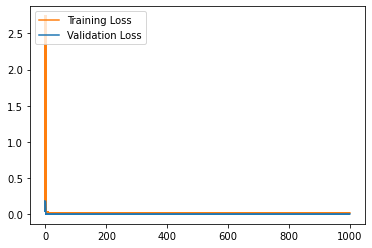

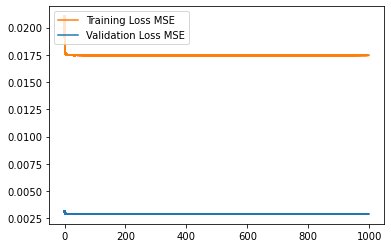

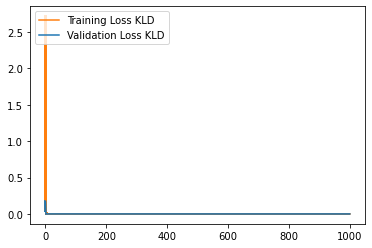

In [8]:
list_train_loss = []
list_val_loss = []
list_train_MSE = []
list_val_MSE = []
list_train_KLD = []
list_val_KLD = []

# fig, axs = plt.subplots(3)
# fig.suptitle('Losses')
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
    
for epoch in range(number_of_epochs):
    start_time = time.time()

    train_run_loss = 0 
    train_run_KLD = 0 
    train_run_MSE = 0 

    val_run_loss = 0
    val_run_KLD = 0
    val_run_MSE = 0

    vae.train(True) # For training
    for image_batch1, y in train_set_loader:
        image_batch1 = image_batch1.cuda()
        autoencoder_optimizer.zero_grad()
        enc_dec_img, mu, logvar = vae(image_batch1)
        train_loss, train_MSE, train_KLD = loss_functionVAE(enc_dec_img, image_batch1, mu, logvar)
        # Backward pass
        train_loss.backward()
        autoencoder_optimizer.step()
        train_run_loss += train_loss.data.item()
        train_run_MSE += train_MSE.data.item()
        train_run_KLD += train_KLD.data.item()

    vae.eval()
    for image_batch2, y in test_set_loader:
        image_batch2 = image_batch2.cuda()
        autoencoder_optimizer.zero_grad()
        enc_dec_img2, mu, logvar = vae(image_batch2)
        val_loss, val_MSE, val_KLD = loss_functionVAE(enc_dec_img2, image_batch2, mu, logvar)
        val_run_loss += val_loss.data.item()
        val_run_MSE += val_MSE.data.item()
        val_run_KLD += val_KLD.data.item()
        
    print('[%d] Loss -> Training: %.7f | Validation: %.7f in %.2f seconds.' % (epoch + 1, train_run_loss/2, val_run_loss/2, time.time() - start_time))
    list_val_loss.append(val_run_loss/5000)
    list_train_loss.append(train_run_loss/5000)
    list_val_MSE.append(val_run_MSE/5000)
    list_train_MSE.append(train_run_MSE/5000)
    list_val_KLD.append(val_run_KLD/5000)
    list_train_KLD.append(train_run_KLD/5000)

    ax1.plot(range(epoch+1),list_train_loss,'tab:orange',label='Training Loss')
    ax1.plot(range(epoch+1),list_val_loss,'tab:blue',label='Validation Loss')
    ax2.plot(range(epoch+1),list_train_MSE,'tab:orange',label='Training Loss MSE')
    ax2.plot(range(epoch+1),list_val_MSE,'tab:blue',label='Validation Loss MSE')
    ax3.plot(range(epoch+1),list_train_KLD,'tab:orange',label='Training Loss KLD')
    ax3.plot(range(epoch+1),list_val_KLD,'tab:blue',label='Validation Loss KLD')
    
    if epoch==0:        
        ax1.legend(loc='upper left')
#         axs[0].xlabel('Epochs')
#         axs[0].ylabel('Loss')
        ax2.legend(loc='upper left')
#         axs[1].xlabel('Epochs')
#         axs[1].ylabel('Loss')
        ax3.legend(loc='upper left')
#         axs[2].xlabel('Epochs')
#         axs[2].ylabel('Loss')

    val_run_loss = 0.0
    train_run_loss = 0.0
    val_run_MSE = 0.0
    train_run_MSE = 0.0
    val_run_KLD = 0.0
    train_run_KLD = 0.0
    
print('Finished Training')

In [9]:
enc_dec_img2, mu, logvar = vae(image_batch2)

In [11]:
enc_dec_img2[0].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


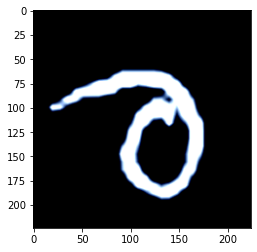

In [26]:
plt.imshow(torch.permute(image_batch2[1], (2, 1, 0)).detach().cpu().numpy())

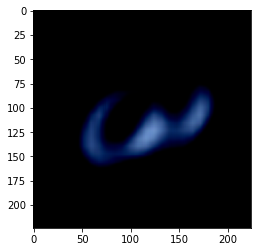

In [27]:
plt.imshow(torch.permute(enc_dec_img2[6], (2, 1, 0)).detach().cpu().numpy())